# Определение возраста покупателей

**Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.**


Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. 

## Исследовательский анализ данных

### Загрузка библиотек

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

### Загрузка данных

In [2]:
datagen_flow = datagen.flow_from_directory(
    '/datasets/faces/',
    target_size=(250, 250), 
    batch_size=10,
    class_mode='sparse',
    seed=12345) 

Found 7591 images belonging to 1 classes.


In [3]:
age = pd.read_csv('/datasets/faces/labels.csv')
age.shape

(7591, 2)

In [4]:
age.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


**Данные загрузились верно. В файле labels.csv содержатся названия файлов и реальный возраст человека на ней**

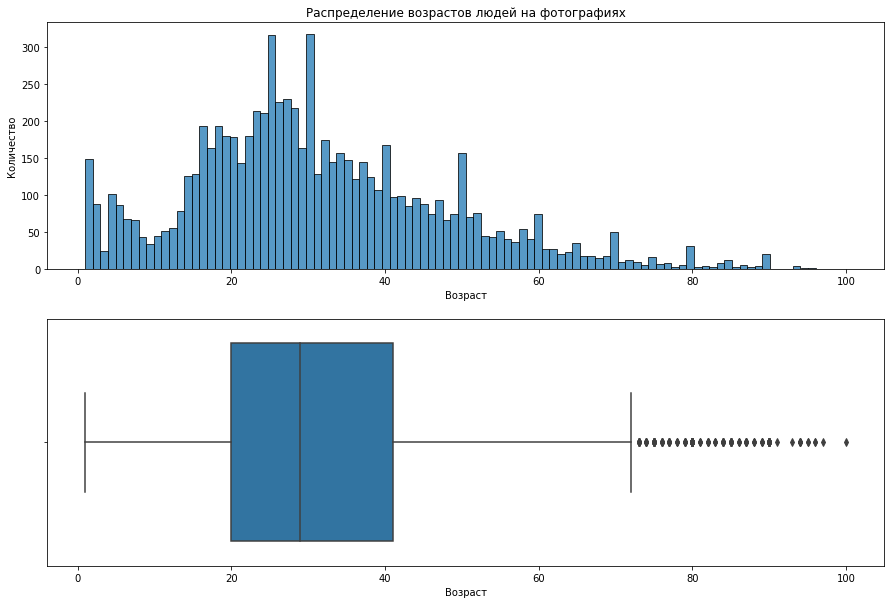

In [19]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
sns.histplot(age['real_age'],bins=100)
plt.title('Распределение возрастов людей на фотографиях')
plt.ylabel('Количество')
plt.xlabel('Возраст')

plt.subplot(2,1,2)
sns.boxplot(age['real_age'])
plt.ylabel('')
plt.xlabel('Возраст')
plt.show()

In [6]:
age.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [7]:
print('Фотографий людей старше 60 лет',round(age[age['real_age']>=60]['real_age'].count()/len(age)*100,2),'%')

Фотографий людей старше 60 лет 6.86 %


**Половина людей на фотографиях имеют возраст от 20 до 40 лет. В датасете представлен достаточных диапазон возрастов, однако, количество фотографий пожилых людей невелико и составляет около 7%. Для увеличения точности модели необходимо расширить датасет**

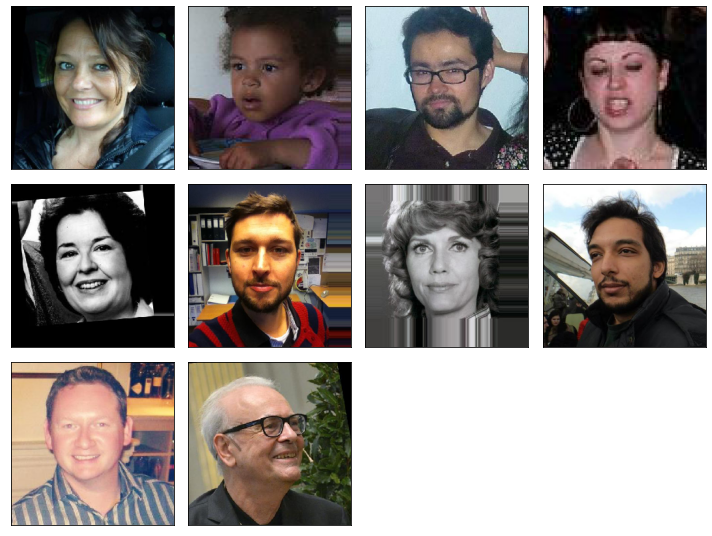

In [25]:
features, target = next(datagen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Выводы исследовательского анализа

Для построения модели предсказания возраста по фото доступно 7591 аннотированных снимков.   
Возраст людей на фотографиях:
- распределен близко к нормальному распределению со смещением влево.
- средний возраст 31 год
- 50% данных заключено в диапазоне от 20 до 41 года
- в датасете небольшое количество фотографий пожилых людей (7%)
- наблюдаются пики на годах, кратных 10. Возможно, возраст некоторых людей оценивался примерно.
Для увеличения качества предсказаний необходимо дополнить датасет фотографиями пожилых людей. Распределение возрастов должно стремится к равномерному.



Фотографии:
- содержат только лицо 
- приведены к одному размеру
- обработаны так, чтобы лица были по центру и расположены по вертикали
- некоторые фотографии предтавлены в черно-белом формате. Это может снизить качество модели
- содержат посторонние предметы около лица (к примеру, микрофон), что также скажется на качестве предсказаний
К фотографиям можно применить отражение по вертикали для учета различных положений лица на фотографии (профиль и полупрофиль)

## Обучение модели

```python
from tensorflow import keras
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd


def load_train(path):
    faces = pd.read_csv(path + 'labels.csv')  
    faces['real_age'] = faces['real_age'].astype('int')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_datagen_flow = datagen.flow_from_dataframe(dataframe=faces,
                                                     directory=path + 'final_files/',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(250, 250),
                                                     batch_size=16,
                                                     class_mode='raw',
                                                     subset='training',
                                                     seed=123)
    return train_datagen_flow

def load_test(path='/datasets/faces/'):
    faces = pd.read_csv(path + 'labels.csv')
    faces['real_age'] = faces['real_age'].astype('int')

    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    test_datagen_flow = datagen.flow_from_dataframe(dataframe=faces,
                                                    directory=path + 'final_files/',
                                                    x_col='file_name',
                                                    y_col='real_age',
                                                    target_size=(250, 250),
                                                    batch_size=16,
                                                    class_mode='raw',
                                                    subset='validation',
                                                    seed=123)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, 
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    
    backbone.trainable = True
    model = Sequential()
    model.add(backbone)    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=7,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
            validation_data=test_data,
            batch_size=batch_size, epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            verbose=2)
    return model

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/7
356/356 - 82s - loss: 238.9450 - mae: 10.9603 - val_loss: 418.3945 - val_mae: 15.2773
Epoch 2/7
356/356 - 46s - loss: 69.1236 - mae: 6.2481 - val_loss: 145.4470 - val_mae: 9.0547
Epoch 3/7
356/356 - 46s - loss: 42.4036 - mae: 5.0029 - val_loss: 90.1011 - val_mae: 7.2312
Epoch 4/7
356/356 - 47s - loss: 31.9991 - mae: 4.3708 - val_loss: 71.2982 - val_mae: 6.3008
Epoch 5/7
356/356 - 46s - loss: 26.4113 - mae: 3.9414 - val_loss: 74.1615 - val_mae: 6.5135
Epoch 6/7
356/356 - 46s - loss: 19.5073 - mae: 3.3745 - val_loss: 69.5149 - val_mae: 6.1732
Epoch 7/7
356/356 - 46s - loss: 15.9049 - mae: 3.0684 - val_loss: 71.2999 - val_mae: 6.2911
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 71.2999 - mae: 6.2911
```

## Выводы

Модель построена на архиектуре ResNet50 с предобучением. 
- Верхние слои были изменены под задачу регресии. 
- За 7 эпох (6 минут обучения) модель достигла MAE = 6.3, что соотвествует поставленной задаче. 
- На 7 эпохе наблюдается повышение функции потерь и рост MAE. Для предотвращения переобучения можно уменьшить количество эпох до 6. 
- Для дальнейшего повышения точности модели можно использовать аугментацию изображения с помощью загрузчика и расширение датасета новыми фотографиями.
    